# Custom Models and Training with TensorFlow

- Reading: Geron, Chapter 12.

### Setup

Requires Python 3.7 or above:

In [2]:
import sys
assert sys.version_info >= (3, 7)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

And TensorFlow ≥ 2.8:

In [3]:
from packaging import version
import tensorflow as tf
print(tf.__version__)
assert version.parse(tf.__version__) >= version.parse("2.8.0")

2.18.0


## A Quick Tour of TensorFlow

- 99% of the use cases you will encounter will **not** require anything other than `Keras` and `tf.data`.

- But taking a look at TensorFlow's lower-level Python API will be useful!

  1. when you need extra control to write custom loss functions, custom metrics, layers, models, initializers, regularizers, weight constraints, and more.
  2. when you want to have a better understanding on what is going on behind the curtains

- TensorFlow is a powerful library for numerical computation, particularly well suited and fine-tuned for large-scale machine learning.

- It was developed by the Google Brain team and it powers many of Google's large-scale services, such as Google Cloud Speech, Google Photos, and Google Search.

- Main Features:

  - Similar to NumPy, but with GPU support.
  - Supports distributed computing (across multiple devices and servers).
  - Just-in-time (JIT) compiler. Extracts the *computation graph* from a Python function and optimizes it.
  - Computation graphs can be exported to a portable format: train using Python on Linux and run it on an Android device
  - Reverse-mode autodiff! 


- At the lowest level, each TensorFlow operation (op for short) is implemented using highly efficient C++ code.

- Many operations have multiple implementations called *kernels*: each kernel is dedicated to a specific device type, such as CPUs, GPUs, or
even TPUs (tensor processing units).

### TensorFlow's Python API

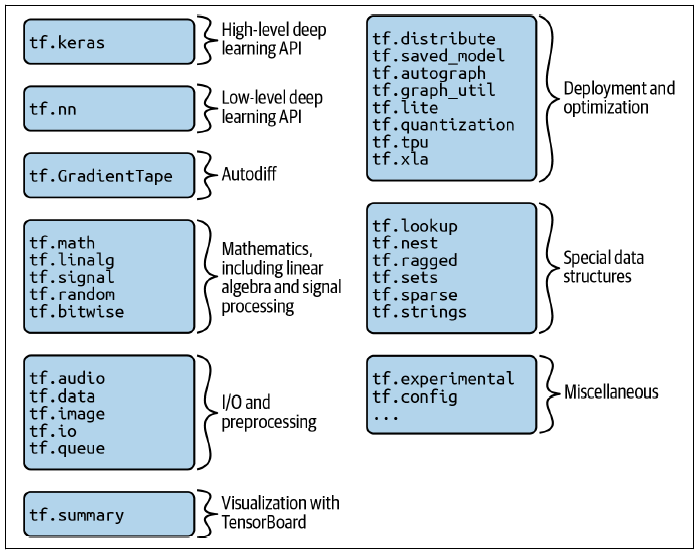

- Most of the time your code will use the high-level APIs (especially `Keras` and `tf.data`)

- But when you need more flexibility you will use the lower-level Python API, handling tensors directly.

### TensorFlow’s architecture

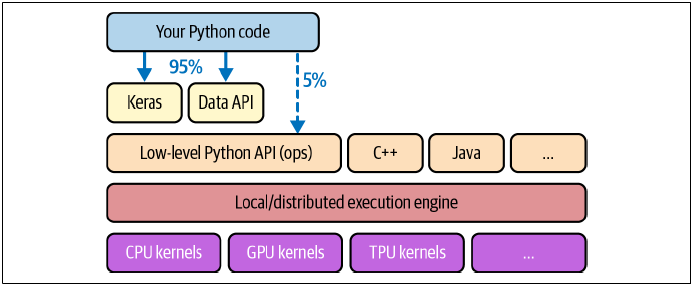

## Using TensorFlow like NumPy

- A tensor is very similar to a NumPy `ndarray`: it is usually a multidimensional array, but it can also hold a scalar.

### Tensors and Operations

- You can create tensors with `tf.constant()`.

In [4]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
t.shape

TensorShape([2, 3])

In [5]:
t.dtype

tf.float32

#### Indexing

In [6]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

#### Ops

In [8]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [9]:
t.__add__(10)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [10]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [11]:
t.numpy().T

array([[1., 4.],
       [2., 5.],
       [3., 6.]], dtype=float32)

In [12]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

#### Scalars

In [13]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

- You will find all the basic math operations you need (`tf.add()` , `tf.multiply()`, `tf.square()`, `tf.exp()`, `tf.sqrt()`, etc.) and most operations that you can find in NumPy (e.g., `tf.reshape()`, `tf.squeeze()`, `tf.tile()`).

- Some functions have a different name than in NumPy; for instance, `tf.reduce_mean()`, `tf.reduce_sum()`, `tf.reduce_max()`, and `tf.math.log()` are the equivalent of `np.mean()`, `np.sum()`, `np.max()`, and `np.log()`.



### Variables

- The `tf.Tensor` values we've seen so far are **immutable**: we cannot modify them.

- This means that we cannot use regular tensors to implement weights in a neural network, since they need to be tweaked by backpropagation.

- Plus, other parameters may also need to change over time (e.g., a momentum optimizer keeps track of past gradients).

In [14]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

- A `tf.Variable` acts much like a `tf.Tensor`: you can perform the same operations with it, it plays nicely with NumPy as well, and it is just as picky with types.

- But it can also be **modified in place** using the `assign()` method (or `assign_add()` or `assign_sub()`, which increment or decrement the variable by the given value).

  - You can also modify individual cells (or slices), by using the cell's (or slice's) `assign()` method:

In [15]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [16]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [17]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [18]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


- In practice you will rarely have to create variables manually; Keras provides an `add_weight()` method that is what you will need 99% of the time.

## Customizing Models and Training Algorithms

#### Example: Custom loss function

- Suppose you want to train a regression model, but your training set is a bit noisy.

- Which loss function should you use? The mean squared error might penalize large errors too
much and cause your model to be imprecise.

- This is probably a good time to use the
Huber loss instead of the good old MSE.

- The Huber loss is available in Keras (`tf.keras.losses.Huber`), but let's pretend it's not there!

- To implement it, just create a function that takes the labels and the model's predictions as arguments, and uses TensorFlow operations to compute a tensor containing all the losses (one per sample):

In [5]:
def huber_fn(y_true, y_pred):
  # Note this implementation is completely vectorized
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1 # Use tf ops only (graph optimized)
  squared_loss = tf.square(error) / 2
  linear_loss  = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_loss, linear_loss)

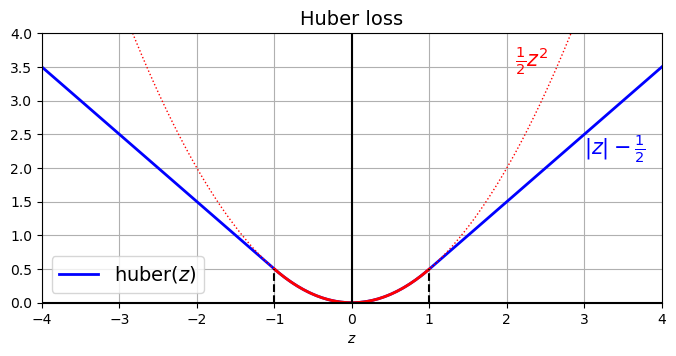

In [20]:
# what the Huber loss looks like
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z|-\frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

To test our custom loss function, let's create a basic Keras model and train it on the California housing dataset:

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(30,
                          activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1),
])

In [8]:
# Compile using CUSTOM LOSS FUNCTION
model.compile(loss=huber_fn,
              optimizer="nadam",
              metrics=["mse", "mae"])

In [10]:
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2186 - mae: 0.5092 - mse: 0.5375 - val_loss: 0.2129 - val_mae: 0.4876 - val_mse: 2.0321
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1989 - mae: 0.4807 - mse: 0.4748 - val_loss: 0.1891 - val_mae: 0.4610 - val_mse: 0.9428
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1894 - mae: 0.4665 - mse: 0.4439 - val_loss: 0.1715 - val_mae: 0.4416 - val_mse: 0.4545
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1831 - mae: 0.4577 - mse: 0.4254 - val_loss: 0.1632 - val_mae: 0.4316 - val_mse: 0.3723
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1786 - mae: 0.4515 - mse: 0.4136 - val_loss: 0.1666 - val_mae: 0.4338 - val_mse: 0.4558


- For each batch during training, Keras calls the `huber_fn()` function to compute the loss, then it uses reverse-mode autodiff to compute the gradients of the loss with regard to all the model parameters, and finally it performs a
gradient descent step (in this example using a Nadam optimizer).

In [12]:
model.save("my_model_with_a_custom_loss.keras")  # saving works fine

- But when you load the model, you need to provide a dictionary that maps the function name to the actual function!

 - More generally, when you load a model containing custom objects, you need to map the names to the objects

In [13]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss.keras",
                                   custom_objects={"huber_fn": huber_fn})

In [14]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1750 - mae: 0.4462 - mse: 0.4047 - val_loss: 0.1827 - val_mae: 0.4477 - val_mse: 1.4596
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1728 - mae: 0.4420 - mse: 0.4012 - val_loss: 0.1593 - val_mae: 0.4234 - val_mse: 0.3993


#### Subclassing

In [15]:
class HuberLoss(tf.keras.losses.Loss):
  '''
  An elegant way to implement a serializable Huber loss
  '''
  def __init__(self, threshold=1.0, **kwargs):
    self.threshold = threshold
    # Handle standard hyperparams (e.g. "name")
    super().__init__(**kwargs)

  def call(self, y_true, y_pred):
    # Compute the losses
    error = y_true - y_pred
    is_small_error = tf.abs(error) < self.threshold
    squared_loss = tf.square(error) / 2
    # Customizable threshold!
    linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
    return tf.where(is_small_error, squared_loss, linear_loss)

  def get_config(self):
    # Must overide this method to make object serializable!
    base_config = super().get_config()
    return {**base_config, "threshold": self.threshold}

In [16]:
# create another basic Keras model
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1),
])

In [18]:
# Compile with the CUSTOM loss object
model.compile(loss=HuberLoss(2.),
              optimizer="nadam", metrics=["mse", "mae"])

In [19]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0421 - mae: 1.1370 - mse: 2.5087 - val_loss: 0.5086 - val_mae: 0.6718 - val_mse: 16.2789
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3175 - mae: 0.5818 - mse: 0.6872 - val_loss: 0.3527 - val_mae: 0.5571 - val_mse: 5.2429


In [20]:
model.save("my_model_with_a_custom_loss_class.keras")  # saving still works

- When you save a model, Keras calls the loss instance's `get_config()` method and saves the config in the SavedModel format.

- When you load the model, Keras calls the `from_config()` class method on the `HuberLoss` class: this method is implemented by the base class (`Loss`) and creates an instance of the class, passing **config to the constructor.

In [21]:
# no need to remember the threshold
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class.keras",
                                   custom_objects={"HuberLoss": HuberLoss})

In [22]:
# loading worked fine, the model can be used normally
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2607 - mae: 0.5239 - mse: 0.5470 - val_loss: 0.2689 - val_mae: 0.4982 - val_mse: 1.7370
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2331 - mae: 0.4930 - mse: 0.4804 - val_loss: 0.2207 - val_mae: 0.4657 - val_mse: 0.6612


In [23]:
model.loss.threshold  # the treshold was loaded correctly

2.0

## Other Custom Functions

#### Activation function and Initializer

In [24]:
def my_softplus(z):
  # Similar to tf.keras.activations.softplus
  return tf.math.log(1.0 + tf.exp(z))

def my_glorot_initializer(shape, dtype=tf.float32):
  # Similar to tf.keras.initializers.glorot_normal
  stddev = tf.sqrt(2. / (shape[0] + shape[1]))
  return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [25]:
# building, training, saving, loading, and training again
# works fine with a model containing many custom parts

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.7772 - mae: 1.2560 - val_loss: 0.6343 - val_mae: 0.5992
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6602 - mae: 0.5996 - val_loss: 0.4939 - val_mae: 0.5182


#### Regularizer

In [26]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
  ''' A serializable custom regularizer
  '''
  def __init__(self, factor):
    self.factor = factor

  def __call__(self, weights):
    # Custom factor
    return tf.reduce_sum(tf.abs(self.factor * weights))

  def get_config(self):
    return {"factor": self.factor}

In [27]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_regularizer=MyL1Regularizer(0.01),
                          kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.8466 - mae: 1.2570 - val_loss: 0.7033 - val_mae: 0.5994
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7295 - mae: 0.6003 - val_loss: 0.5649 - val_mae: 0.5198


In [28]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.800000011920929>

In [29]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

- After the first batch, it returns a precision of 80%; then after the second batch, it returns 50% (which is the overall precision so far, not the second batch’s precision).

- This is called a **streaming metric** (or stateful metric), as it is gradually updated, batch after batch.

In [30]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [31]:
precision.variables

[<KerasVariable shape=(1,), dtype=float32, path=precision/true_positives>,
 <KerasVariable shape=(1,), dtype=float32, path=precision/false_positives>]

In [32]:
precision.reset_states()

AttributeError: 'Precision' object has no attribute 'reset_states'

Creating a streaming metric:

In [33]:
class HuberMetric(tf.keras.metrics.Metric):
  '''
  Serializable streaming metric. Keeps track of
  the total Huber loss and the number of instances seen so far.
  '''
  def __init__(self, threshold=1.0, **kwargs):
    super().__init__(**kwargs)  # handles base args (e.g., dtype)
    self.threshold = threshold
    self.huber_fn = create_huber(threshold)
    # Create tf.Variable's (Keras will automatically track them)
    self.total = self.add_weight("total", initializer="zeros")
    self.count = self.add_weight("count", initializer="zeros")

  def update_state(self, y_true, y_pred, sample_weight=None):
    # method called when you use an instance of this class as a function
    sample_metrics = self.huber_fn(y_true, y_pred)
    # sample weights are ignored in this example
    # Note the use of assign_add
    self.total.assign_add(tf.reduce_sum(sample_metrics))
    self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

  def result(self):
    # Compute mean Huber metric
    return self.total / self.count

  def get_config(self):
    # Serialize the threshold
    base_config = super().get_config()
    return {**base_config, "threshold": self.threshold}

Let's check that the `HuberMetric` class works well:

In [34]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

c:\Users\310\Desktop\Progects_Py\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

NameError: name 'create_huber' is not defined

In [36]:
model.fit(X_train_scaled, y_train, epochs=2)

ValueError: You must call `compile()` before using the model.

In [ ]:
model.save("my_model_with_a_custom_metric")

In [ ]:
model = tf.keras.models.load_model("my_model_with_a_custom_metric",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.2416 - huber_metric_1: 0.2416
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2173 - huber_metric_1: 0.2173


`model.metrics` contains the model's loss followed by the model's metric(s), so the `HuberMetric` is `model.metrics[-1]`:

In [ ]:
model.metrics[-1].threshold

2.0

## Custom Layers

- You may occasionally want to build an architecture that contains an exotic layer for
which TensorFlow does not provide a default implementation.

- Or you may simply want to build a very repetitive architecture, in which a particular block of layers is repeated many times, and it would be convenient to treat each block as a single layer.

#### Custom layers without weights

- If you want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a layer `tf.keras.layers.Lambda`

In [37]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [38]:
# like all layers, it can be used as a function:
exponential_layer(tf.constant([-1., 0., 1.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000).

In [39]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1),
    exponential_layer,
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)


Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2333 - val_loss: 0.4393
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6172 - val_loss: 0.4048
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5170 - val_loss: 0.3942
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4499 - val_loss: 0.3699
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5426 - val_loss: 0.3765
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3919


0.39457282423973083

Alternatively, it's often preferable to replace the targets with the logarithm of the targets (and use no activation function in the output layer).

#### Custom Stateful Layers

- To build a custom stateful layer (i.e., a layer with weights), you need to create a subclass of `tf.keras.layers.Layer`.

In [41]:
class MyDense(tf.keras.layers.Layer):
  '''
  A custom stateful dense layer
  '''
  def __init__(self, units, activation=None, **kwargs):
    # Call tf.keras.layers.Layer's constructor, passing it the kwargs
    super().__init__(**kwargs)
    # Store hyperparams
    self.units = units
    self.activation = tf.keras.activations.get(activation)

  def build(self, batch_input_shape):
    '''
    This method is called the first time the layer is used.
    This allows flexibility for different input sizes
    '''
    # Create the layer's variables
    self.kernel = self.add_weight(
        name="kernel", shape=[batch_input_shape[-1], self.units],
        initializer="he_normal")
    self.bias = self.add_weight(
        name="bias", shape=[self.units], initializer="zeros")

  def call(self, X):
    '''
    This method is used by tf compiler to create the computational graph
    '''
    return self.activation(X @ self.kernel + self.bias)

  def get_config(self):
    '''
    This method makes the layer easily serializable
    '''
    base_config = super().get_config()
    return {**base_config,
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation)}

In [43]:
# a custom layer can be used normally
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    MyDense(30, activation="relu"),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.7265 - val_loss: 6.9255
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9550 - val_loss: 2.6011
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7227


0.7036542296409607

#### A layer with a different behavior during training and testing:

In [44]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        '''Note the training kw arg'''
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

Here's a simple model that uses this custom layer:

In [45]:
# tests MyGaussianNoise
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    MyGaussianNoise(stddev=1.0),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.7619 - val_loss: 25.1369
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3953 - val_loss: 14.9793
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1221


1.1244221925735474

## Custom Models

- This is another name for the "subclassing API" we discussed earlier.

  1. Subclass the `tf.keras.Model` class
  2. Create layers and variables in the constructor (`__init__()`))
  3. Implement the `call()` method to do whatever you want the model to do.
  4. Optionally, implement `get_config()` to make the model serializable  



An example:

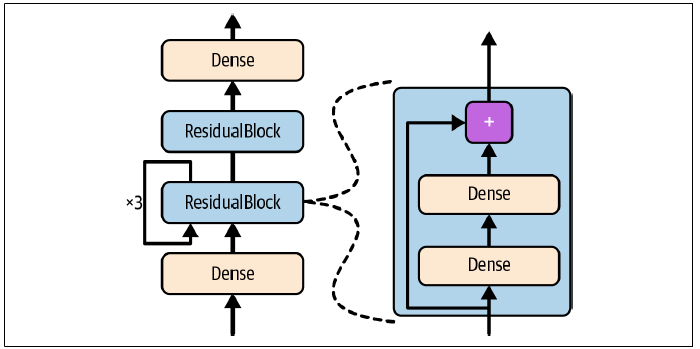

In [46]:
# First create the Residual Block Layer
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self, n_layers, n_neurons, **kwargs):
    super().__init__(**kwargs)
    # We allow a flexible number of layers
    # We hard-code activation/initializer for this example
    self.n_layers = n_layers
    self.n_neurons = n_neurons
    self.hidden = [tf.keras.layers.Dense(n_neurons,
                                         activation="relu",
                                         kernel_initializer="he_normal")
                    for _ in range(n_layers)]

  def call(self, inputs):
    Z = inputs
    for layer in self.hidden:
        Z = layer(Z)
    return inputs + Z

  def get_config(self):
    '''
    This method makes the sub-model easily serializable
    '''
    base_config = super().get_config()
    return {**base_config,
            "n_neurons": self.n_neurons,
            "n_layers": self.n_layers,}

In [47]:
# Custom Model
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        # We hard code n_layers and n_neurons to keep it simple
        self.hidden1 = tf.keras.layers.Dense(30,
                                          activation="relu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    def get_config(self):
        '''
        This method makes the model easily serializable
        '''
        base_config = super().get_config()
        return {**base_config,
                "output_dim": self.out,}

In [48]:
# the model can be used normally
tf.keras.utils.set_random_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 123.3031
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5416
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1639


In [ ]:
class ReconstructingRegressor(tf.keras.Model):
  def __init__(self, output_dim, **kwargs):
    super().__init__(**kwargs)
    # Five stacked dense layers
    self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                          kernel_initializer="he_normal")
                    for _ in range(5)]

    # The main output layer
    self.out = tf.keras.layers.Dense(output_dim)

    # Mean Streaming Metric to keep track of reconstruction error
    self.reconstruction_mean = tf.keras.metrics.Mean(name="reconstruction_error")

  def build(self, batch_input_shape):
    n_inputs = batch_input_shape[-1]
    # Auxiliary output layer
    self.reconstruct = tf.keras.layers.Dense(n_inputs)

  def call(self, inputs, training=None):
    Z = inputs
    for layer in self.hidden:
        Z = layer(Z)
    reconstruction = self.reconstruct(Z)
    # Calculate reconstruction error loss
    recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
    # Add reconstruction loss to overall loss (note the hard-coded scale param)
    self.add_loss(0.05 * recon_loss)
    if training:
      result = self.reconstruction_mean(recon_loss)
      # Custom metric
      self.add_metric(result)
    return self.out(Z)

In [ ]:
# Let's test it
tf.keras.utils.set_random_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 [==============================] - 5s 4ms/step - loss: 0.8198 - reconstruction_error: 1.0892
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4778 - reconstruction_error: 0.5583
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4419 - reconstruction_error: 0.4227
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3852 - reconstruction_error: 0.3587
Epoch 5/5
162/162 [==============================] - 0s 2ms/step


# Computing Gradients Using Autodiff

- To understand how to use autodiff, consider a simple example:

- $f(w_1,w_2) = 3w_1^2 + 2w_1 w_2$

- $∇f(w_1,w_2)=\left(\frac{\partial f}{\partial w_1}, \frac{\partial f}{\partial w_2}\right)^T=\left(6w_1 + 2w_2, 2w_1\right)^T$

- $∇f(w_1,w_2)\vert_{(5,3)} = (36, 10)^T$

In [49]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [52]:
# Numerical approx
w1, w2 = 5, 3
eps = 1e-7
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.00000042069951

In [55]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

9.999999974752427

- This works rather well and is easy to implement

- But it is just an approximation, and importantly you need to call $f()$ at least once per parameter.

- Having to call $f()$ at least once per parameter makes this approach intractable for large neural networks.

### Reverse-mode Autodiff

In [56]:
# 1. Turn variables into tensors
w1, w2 = tf.Variable(5.), tf.Variable(3.)

# 2. Create a tf.GradientTape context
with tf.GradientTape() as tape:
    # 3. Define the function WITHIN the tape context
    z = f(w1, w2)

# 4. Now the gradients are available
gradients = tape.gradient(z, [w1, w2])

In [57]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

1. We define two `tf.Variable` tensors
2. We create a `tf.GradientTape` context that will automatically record every operation that involves a variable

3. Finally, we ask this `tape` to compute the gradients of the result `z` with regard to both variables `[w1, w2]`.


- The result accurate: the precision is only limited by the floatingpoint errors
- The `gradient()` method only goes through the recorded computations once (in reverse order), no matter how many variables there are, so it is
incredibly efficient!

**Note**: The tape is automatically erased immediately after you call its `gradient()` method, so you will get an exception if you try to call `gradient()` twice:

In [58]:
with tf.GradientTape() as tape:
  z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
try:
  dz_dw2 = tape.gradient(z, w2)  # raises a RuntimeError!
except RuntimeError as ex:
  print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


If you need to call `gradient()` more than once, you must make the tape persistent and delete it each time you are done with it to free resources.

In [59]:
with tf.GradientTape(persistent=True) as tape:
  z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

In [60]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

- Most of the time a gradient tape is used to compute the gradients of a single value (usually the loss) with regard to a set of values (usually the model parameters).

- This is where reverse-mode autodiff shines, as it just needs to do one forward pass and
one reverse pass to get all the gradients at once.


## Custom Training Loops

- In some cases, the `fit()` method may not be flexible enough for what you need to do.

    - For example, the Wide & Deep paper uses *two different optimizers*: one for the wide path and the other for the deep path.
    - Since the `fit()` method only uses one optimizer (the one that we specify when "compiling" the model), implementing this paper requires writing your own custom loop.

- You may also like to write custom training loops simply to feel more confident that they do precisely what you intend them to do.



In [61]:
# A simple model with regularization
tf.keras.utils.set_random_seed(42)  # to ensure reproducibility
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(30,
                          activation="relu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

- **No need to "compile", since we will handle the training loop manually**.

- We will need a tiny function to randomly sample a batch of instances from the training set:


In [62]:
def random_batch(X, y, batch_size=32):
  idx = np.random.randint(len(X), size=batch_size)
  return X[idx], y[idx]


- And another tiny function to print status as we train:

In [63]:
def print_status_bar(step, total, loss, metrics=None):
  metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                        for m in [loss] + (metrics or [])])
  end = "" if step < total else "\n"
  print(f"\r{step}/{total} - " + metrics, end=end)

In [64]:
tf.keras.utils.set_random_seed(42)

#### First, we need to define some hyperparameters and choose the optimizer, the loss function, and the metrics:

In [65]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MSE
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

#### Here is our **custom training loop**

In [67]:
# Loop over epochs
for epoch in range(1, n_epochs + 1):
  print(f"Epoch {epoch}/{n_epochs}")

  # Loop over batches
  for step in range(1, n_steps + 1):
    # Get a batch
    X_batch, y_batch = random_batch(X_train_scaled, y_train)

    # GradientTape Context
    with tf.GradientTape() as tape:
      # Obtain predictions
      y_pred = model(X_batch, training=True)  # SET training=True
      # Get main loss
      main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
      # Add regularization losses (result is a scalar tensor)
      #print(f"{model.losses=}")
      loss = tf.add_n([main_loss] + model.losses)

    # backprop
    gradients = tape.gradient(loss, model.trainable_variables)
    # every optimizer has this method
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # if your weights have constraints
    for variable in model.variables:
      if variable.constraint is not None:
        variable.assign(variable.constraint(variable))

    mean_loss(loss)
    for metric in metrics:
      metric(y_batch, y_pred)

    print_status_bar(step, n_steps, mean_loss, metrics)

  # Reset metrics when epoch ends
  for metric in [mean_loss] + metrics:
    metric.reset_state()

Epoch 1/5
362/362 - mean: 0.6763 - mean_absolute_error: 0.5042
Epoch 2/5
362/362 - mean: 0.6328 - mean_absolute_error: 0.4974
Epoch 3/5
362/362 - mean: 0.6241 - mean_absolute_error: 0.4980
Epoch 4/5
362/362 - mean: 0.6044 - mean_absolute_error: 0.4941
Epoch 5/5
362/362 - mean: 0.6258 - mean_absolute_error: 0.5021


In [68]:
# use the tqdm package to display nice progress bars

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
  for epoch in epochs:
    with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
      for step in steps:
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
          y_pred = model(X_batch)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        for variable in model.variables:
          if variable.constraint is not None:
            variable.assign(variable.constraint(variable))

        status = OrderedDict()
        mean_loss(loss)
        status["loss"] = mean_loss.result().numpy()
        for metric in metrics:
          metric(y_batch, y_pred)
          status[metric.name] = metric.result().numpy()

        steps.set_postfix(status)

    for metric in [mean_loss] + metrics:
      metric.reset_state()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## TensorFlow Functions

- Since TensorFlow 2 (released in 2019), computational graphs are much simpler to use.

In [69]:
def cube(x):
  return x ** 3

- We can call this function with a Python value, such as an int or a float, or we can call it with a tensor:

In [70]:
cube(2)

8

In [71]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

#### `tf.function` converts Python functions into TensorFlow functions:

In [72]:
tf_cube = tf.function(cube)
tf_cube

- TF functions return tensors:

In [73]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [74]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

- Under the hood, `tf.function()` analyzed the computations performed by the `cube()` function and generated an equivalent computation graph!

- Alternatively, we could have used `tf.function` as a decorator:

In [75]:
@tf.function
def tf_cube(x):
  return x ** 3

In [76]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [77]:
# If you need the original Python function
tf_cube.python_function(2)

8

#### What `tf.function` does

- TensorFlow optimizes the computation graph, pruning unused nodes, simplifying expressions (e.g., 1 + 2 would get replaced with 3), and more.

- Once the optimized graph is ready, the TF function efficiently executes the operations in the graph, in the appropriate order (**and in parallel** when it can).

- As a result, a TF function will usually run much faster than the original Python function, especially if it performs complex computations.

- **Most of the time you will not really need to know more than that: when you want to boost a Python function, just transform it into a TF function. That's all!**

- If you set `jit_compile=True` when calling `tf.function()`, then TensorFlow will use accelerated linear algebra (XLA) to compile dedicated kernels for your graph, often fusing multiple operations.
  - For example, if your TF function calls
`tf.reduce_sum(a*b+c)`, then without XLA the function would first need to compute a*b and store the result in a temporary variable, then add c to that variable, and lastly call `tf.reduce_sum()` on the result.
  - With XLA, the whole computation gets compiled into a single kernel, which will compute `tf.reduce_sum(a*b+c)` in one shot, without using any large temporary variable (much faster and also uses dramatically less RAM).

- **When you write a custom loss function, a custom metric, a custom layer, or any other
custom function and you use it in a Keras model, Keras automatically converts your function into a TF function** — no need
to use `tf.function()`.

  - If you want Keras to use XLA, you just need to set `jit_compile=True` when calling the `compile()` method.

### TF Functions and Concrete Functions

- TF functions are *polymorphic*, meaning they support inputs of different types (and
shapes).

- Every time you call a TF function with a new combination of input types or shapes, it generates a new **concrete function**, with its own graph specialized for this particular combination.

- Such a combination of argument types and shapes is called an **input signature**.

- If you call the TF function with an input signature it has already seen before, it will reuse the concrete function it generated earlier.

- You can get the concrete function for a particular combination of inputs by calling the TF function's `get_concrete_function()` method.


In [78]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function

<ConcreteFunction (x: TensorSpec(shape=(), dtype=tf.float32, name=None)) -> TensorSpec(shape=(), dtype=tf.float32, name=None) at 0x1D9383309E0>

The concrete function can then be called like a regular function, but it will only support one input signature:

In [79]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [80]:
try:
  concrete_function(tf.constant(2, dtype='int32'))
except Exception as e:
  print(e)

cannot compute __inference_tf_cube_925304 as input #0(zero-based) was expected to be a float tensor but is a int32 tensor [Op:__inference_tf_cube_925304]


### Exploring Function Definitions and Graphs

- The `tf_cube()` TF function generated two concrete functions, one for each signature:

   - `tf_cube(2)`
   - `tf_cube(tf.constant(2.0))`

- Eac concrete function has its own **optimized function graph** (`FuncGraph`) and its own **function definition** (`FunctionDef`).

- A function definition points to the parts of the graph that correspond to the function's inputs and outputs.

- In each `FuncGraph`, the nodes (ovals) represent operations (e.g., power, constants, or placeholders for arguments like $x$), while the edges (the solid arrows between the operations) represent the tensors that will flow through the graph.



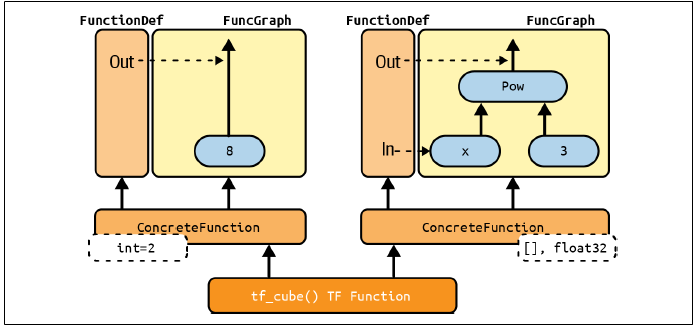

- The concrete function on the left is
specialized for $x=2$, so TensorFlow managed to simplify it to just output $8$ all the
time (**note that the function definition does not even have an input**).

- The concrete function on the right is specialized for float32 scalar tensors, and it could not be simplified.
  - If we call `tf_cube(tf.constant(5.0))`, the second concrete function will be called, the placeholder operation for $x$ will output $5.0$, then the power operation will compute $5.0^3$, so the output will be $125.0$.

- The tensors in these graphs are **symbolic tensors**, meaning they don't have an actual
value.

- Symbolic tensor have a data type, a shape, and a name. They represent the future tensors that will flow through the graph once an actual value is fed to the placeholder $x$ and the
graph is executed.

- Symbolic tensors make it possible to specify ahead of time how to connect operations, and they also allow TensorFlow to recursively infer the data types and shapes of all tensors, given the data types and shapes of their inputs.

In [81]:
# Access the concrete function's graph
concrete_function.graph

In [82]:
# List of graph operations
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

- The first operation represents the input argument $x$ (it is called a **placeholder**)

- The second "operation" represents the constant $3$ (the power)

- The third operation represents the power operation (**), and the final operation represents the output of this function.

- Each operation has a list of input and output
tensors that you can easily access using the operation's `inputs` and `outputs` attributes.

In [103]:
ops[1].node_def

name: "pow/y"
op: "Const"
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_FLOAT
      tensor_shape {
      }
      float_val: 3
    }
  }
}
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}

In [83]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [84]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

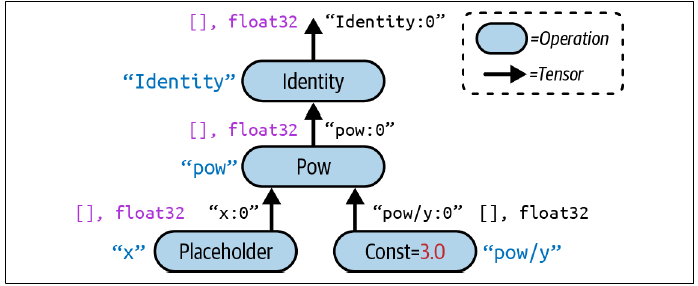

- Each operation has a name:
  - The default is the name of the operation (e.g., "pow"), but you can set it manually.
  - If a name already exists, TensorFlow automatically adds a unique index (e.g., "pow_1", "pow_2", etc.).
  
- Each tensor also has a unique name:
  - it is always the name of the operation that outputs this tensor, plus :0 if it is the
operation's first output, or :1 if it is the second output, and so on.

- You can fetch an operation or a tensor by name using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [104]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [105]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

- The concrete function also contains the function definition, which includes the function's signature.

- This signature allows the concrete function to know which placeholders to feed with the input values, and which tensors to return:

In [106]:
concrete_function.function_def.signature

name: "__inference_tf_cube_925304"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

## Autograph and Tracing

1. TensorFlow starts by analyzing the Python function's source code to capture all the control flow statements, such as `for` loops, `while` loops, and `if` statements, as well as `break`, `continue`, and `return` statements.

- This first step is called **AutoGraph**.

- The reason TensorFlow has to analyze the source code is that Python does not provide any other way to capture control flow statements:
  - Python offers magic methods like `__add__()` to capture operators like + but there are no `__while__()` or `__if__()` magic methods.

- AutoGraph outputs an upgraded version of the function in which all the control flow statements are replaced by the appropriate TensorFlow operations, such as `tf.while_loop()` for loops and `tf.cond()` for if statements.

##### Example - Autograph  analyzes the `sum_squares()` Python function and it generates the `tf__sum_squares()` function:



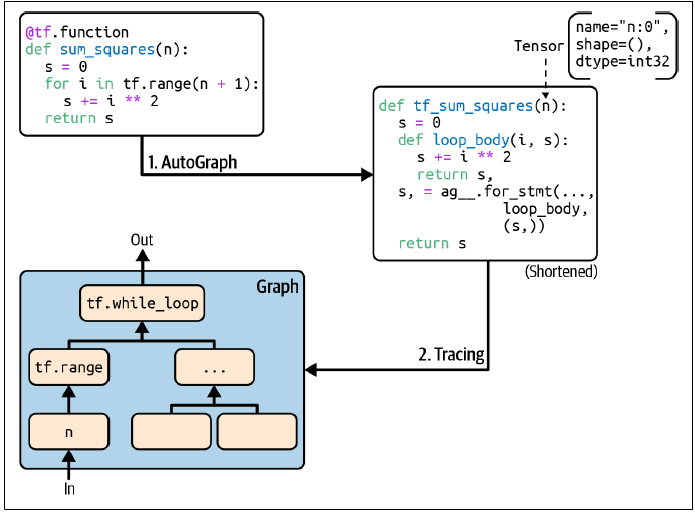

- In `tf__sum_squares()`, the for loop is replaced by the definition of the `loop_body()` function (containing the body of the original for loop), followed by a call to the `for_stmt()` function.

- This call will build the appropriate `tf.while_loop()` operation in the computation graph.

2. Next, TensorFlow calls the “upgraded” function, but instead of passing the argument,
it passes a symbolic tensor — a tensor without any actual value, only a name, a data
type, and a shape.

  - For example, if you call `sum_squares(tf.constant(10))`, then the `tf__sum_squares()` function will be called with a symbolic tensor of type `int32` and shape `[]`.

- The function will run in **graph mode**, meaning that each TensorFlow operation will add a node in the graph to represent itself and its output tensor(s).

- The alternative to graph mode is regular mode, called **eager execution**, or eager mode.

- In graph mode, TF operations do not perform any computations.

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [107]:
# Tweak tf_cube() to print its input:

@tf.function
def tf_cube(x):
  print(f"x = {x}")
  return x ** 3

In [108]:
result = tf_cube(tf.constant(2.0))

x = Tensor("x:0", shape=(), dtype=float32)


In [109]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

- The `result` looks good, but look at what was printed: $x$ is a symbolic tensor!

  - It has a shape and a data type, but no value.
  - It has a name ("x:0").
  
- The reason is that the `print()` function is **not** a TensorFlow operation, so it will only run when the Python function is *traced*, which happens in *graph mode*, with arguments replaced with symbolic tensors.

- Since `print()` was not captured into the graph, the next times we call `tf_cube()` with float32 scalar tensors, nothing is printed:

In [110]:
result = tf_cube(tf.constant(3.0))

- But if we call `tf.cube()` with a tensor of a different type or shape, or with a new Python value, the function will be traced again, and `print()` will be called:

In [111]:
result = tf_cube(2)

x = 2


In [112]:
result = tf_cube(3)

x = 3


In [113]:
result = tf_cube(tf.constant([[1., 2.]]))  # New shape: trace!

x = Tensor("x:0", shape=(1, 2), dtype=float32)


In [114]:
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))  # New shape: trace!

x = Tensor("x:0", shape=(2, 2), dtype=float32)


In [115]:
result = tf_cube(tf.constant([[7., 8.], [9., 10.]]))  # Same shape: no trace

It is also possible to specify a particular input signature:

In [116]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
  print("Tracing... ", images)  # show when tracing happens
  return images[:, ::2, ::2] # drop half the rows and columns

In [117]:
tf.keras.utils.set_random_seed(42)

In [118]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)  # Works fine, traces the function
preprocessed_images = shrink(img_batch_2)  # Works fine, same concrete function

Tracing...  Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [ ]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
  preprocessed_images = shrink(img_batch_3)  # TypeError! Incompatible inputs
except TypeError as ex:
  print(ex)

Binding inputs to tf.function failed due to `Can not cast TensorSpec(shape=(2, 2, 2), dtype=tf.float32, name=None) to TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)`. Received args: (<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.7413678 , 0.62854624],
        [0.01738465, 0.3431449 ]],

       [[0.51063764, 0.3777541 ],
        [0.07321596, 0.02137029]]], dtype=float32)>,) and kwargs: {} for signature: (images: TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


In order to view the generated TF function's source code, you can call `tf.autograph.to_code`:

In [122]:
from pprint import pprint
pprint(tf.autograph.to_code(tf_cube.python_function))

('def tf__tf_cube(x):\n'
 "    with ag__.FunctionScope('tf_cube', 'fscope', "
 'ag__.ConversionOptions(recursive=True, user_requested=True, '
 'optional_features=(), internal_convert_user_code=True)) as fscope:\n'
 '        do_return = False\n'
 '        retval_ = ag__.UndefinedReturnValue()\n'
 "        ag__.ld(print)(f'x = {ag__.ld(x)}')\n"
 '        try:\n'
 '            do_return = True\n'
 '            retval_ = ag__.ld(x) ** 3\n'
 '        except:\n'
 '            do_return = False\n'
 '            raise\n'
 '        return fscope.ret(retval_, do_return)\n')


In [123]:
# how to display the autograph code with syntax highlighting
def display_tf_code(func):
  from IPython.display import display, Markdown
  if hasattr(func, "python_function"):
    func = func.python_function
  code = tf.autograph.to_code(func)
  display(Markdown(f'```python\n{code}\n```'))

In [124]:
display_tf_code(tf_cube)

```python
def tf__tf_cube(x):
    with ag__.FunctionScope('tf_cube', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        ag__.ld(print)(f'x = {ag__.ld(x)}')
        try:
            do_return = True
            retval_ = ag__.ld(x) ** 3
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

---

---
# Exercises

## 1. to 11.

1. TensorFlow is an open-source library for numerical computation, particularly well suited and fine-tuned for large-scale Machine Learning. Its core is similar to NumPy, but it also features GPU support, support for distributed computing, computation graph analysis and optimization capabilities (with a portable graph format that allows you to train a TensorFlow model in one environment and run it in another), an optimization API based on reverse-mode autodiff, and several powerful APIs such as tf.keras, tf.data, tf.image, tf.signal, and more. Other popular Deep Learning libraries include PyTorch, MXNet, Microsoft Cognitive Toolkit, Theano, Caffe2, and Chainer.
2. Although TensorFlow offers most of the functionalities provided by NumPy, it is not a drop-in replacement, for a few reasons. First, the names of the functions are not always the same (for example, `tf.reduce_sum()` versus `np.sum()`). Second, some functions do not behave in exactly the same way (for example, `tf.transpose()` creates a transposed copy of a tensor, while NumPy's `T` attribute creates a transposed view, without actually copying any data). Lastly, NumPy arrays are mutable, while TensorFlow tensors are not (but you can use a `tf.Variable` if you need a mutable object).
3. Both `tf.range(10)` and `tf.constant(np.arange(10))` return a one-dimensional tensor containing the integers 0 to 9. However, the former uses 32-bit integers while the latter uses 64-bit integers. Indeed, TensorFlow defaults to 32 bits, while NumPy defaults to 64 bits.
4. Beyond regular tensors, TensorFlow offers several other data structures, including sparse tensors, tensor arrays, ragged tensors, queues, string tensors, and sets. The last two are actually represented as regular tensors, but TensorFlow provides special functions to manipulate them (in `tf.strings` and `tf.sets`).
5. When you want to define a custom loss function, in general you can just implement it as a regular Python function. However, if your custom loss function must support some hyperparameters (or any other state), then you should subclass the `keras.losses.Loss` class and implement the `__init__()` and `call()` methods. If you want the loss function's hyperparameters to be saved along with the model, then you must also implement the `get_config()` method.
6. Much like custom loss functions, most metrics can be defined as regular Python functions. But if you want your custom metric to support some hyperparameters (or any other state), then you should subclass the `keras.metrics.Metric` class. Moreover, if computing the metric over a whole epoch is not equivalent to computing the mean metric over all batches in that epoch (e.g., as for the precision and recall metrics), then you should subclass the `keras.metrics.Metric` class and implement the `__init__()`, `update_state()`, and `result()` methods to keep track of a running metric during each epoch. You should also implement the `reset_states()` method unless all it needs to do is reset all variables to 0.0. If you want the state to be saved along with the model, then you should implement the `get_config()` method as well.
7. You should distinguish the internal components of your model (i.e., layers or reusable blocks of layers) from the model itself (i.e., the object you will train). The former should subclass the `keras.layers.Layer` class, while the latter should subclass the `keras.models.Model` class.
8. Writing your own custom training loop is fairly advanced, so you should only do it if you really need to. Keras provides several tools to customize training without having to write a custom training loop: callbacks, custom regularizers, custom constraints, custom losses, and so on. You should use these instead of writing a custom training loop whenever possible: writing a custom training loop is more error-prone, and it will be harder to reuse the custom code you write. However, in some cases writing a custom training loop is necessary⁠—for example, if you want to use different optimizers for different parts of your neural network, like in the [Wide & Deep paper](https://homl.info/widedeep). A custom training loop can also be useful when debugging, or when trying to understand exactly how training works.
9. Custom Keras components should be convertible to TF Functions, which means they should stick to TF operations as much as possible and respect all the rules listed in Chapter 12 (in the _TF Function Rules_ section). If you absolutely need to include arbitrary Python code in a custom component, you can either wrap it in a `tf.py_function()` operation (but this will reduce performance and limit your model's portability) or set `dynamic=True` when creating the custom layer or model (or set `run_eagerly=True` when calling the model's `compile()` method).
10. Please refer to Chapter 12 for the list of rules to respect when creating a TF Function (in the _TF Function Rules_ section).
11. Creating a dynamic Keras model can be useful for debugging, as it will not compile any custom component to a TF Function, and you can use any Python debugger to debug your code. It can also be useful if you want to include arbitrary Python code in your model (or in your training code), including calls to external libraries. To make a model dynamic, you must set `dynamic=True` when creating it. Alternatively, you can set `run_eagerly=True` when calling the model's `compile()` method. Making a model dynamic prevents Keras from using any of TensorFlow's graph features, so it will slow down training and inference, and you will not have the possibility to export the computation graph, which will limit your model's portability.

## 12. Implement a custom layer that performs _Layer Normalization_
_We will use this type of layer in Chapter 15 when using Recurrent Neural Networks._

### a.
_Exercise: The `build()` method should define two trainable weights *α* and *β*, both of shape `input_shape[-1:]` and data type `tf.float32`. *α* should be initialized with 1s, and *β* with 0s._

Solution: see below.

### b.
_Exercise: The `call()` method should compute the mean_ μ _and standard deviation_ σ _of each instance's features. For this, you can use `tf.nn.moments(inputs, axes=-1, keepdims=True)`, which returns the mean μ and the variance σ<sup>2</sup> of all instances (compute the square root of the variance to get the standard deviation). Then the function should compute and return *α*⊗(*X* - μ)/(σ + ε) + *β*, where ⊗ represents itemwise multiplication (`*`) and ε is a smoothing term (small constant to avoid division by zero, e.g., 0.001)._

In [ ]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

Note that making _ε_ a hyperparameter (`eps`) was not compulsory. Also note that it's preferable to compute `tf.sqrt(variance + self.eps)` rather than `tf.sqrt(variance) + self.eps`. Indeed, the derivative of sqrt(z) is undefined when z=0, so training will bomb whenever the variance vector has at least one component equal to 0. Adding _ε_ within the square root guarantees that this will never happen.

### c.
_Exercise: Ensure that your custom layer produces the same (or very nearly the same) output as the `tf.keras.layers.LayerNormalization` layer._

Let's create one instance of each class, apply them to some data (e.g., the training set), and ensure that the difference is negligeable.

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = tf.keras.layers.LayerNormalization()

tf.reduce_mean(tf.keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.9782837e-08>

Yep, that's close enough. To be extra sure, let's make alpha and beta completely random and compare again:

In [ ]:
tf.keras.utils.set_random_seed(42)
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(tf.keras.losses.mean_absolute_error(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.764704e-08>

Still a negligeable difference! Our custom layer works fine.

## 13. Train a model using a custom training loop to tackle the Fashion MNIST dataset
_The Fashion MNIST dataset was introduced in Chapter 10._

### a.
_Exercise: Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

### b.
_Exercise: Try using a different optimizer with a different learning rate for the upper layers and the lower layers._

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
lower_layers = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
])
upper_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax"),
])
model = tf.keras.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]